In [245]:
import os
from os import path

import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import h5py
from dustmaps.sfd import SFDQuery
from scipy.stats import truncnorm
from scipy.interpolate import interp1d
from pygaia.errors import photometric, astrometric, spectroscopic

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

from brokenimf import new_kroupa_mass_distribution

In [276]:
iso_path = '/Users/apricewhelan/data/Isochrones/MIST/'
sfd = SFDQuery()

out_path = path.abspath('../data/gaia_mock_streams/')
os.makedirs(out_path, exist_ok=True)

In [277]:
def apw_truncnorm(mu, sigma, clip_a, clip_b, **kwargs):
    a, b = (clip_a - mu) / sigma, (clip_b - mu) / sigma
    return truncnorm(a, b, loc=mu, scale=sigma, **kwargs)

In [278]:
galcen_frame = gc.get_galactocentric2019()
feh_dist = apw_truncnorm(-1.5, 0.5, -2.1, -0.5)
age_dist = apw_truncnorm(12, 1., 10, 13.5)

In [279]:
def get_ks(A0, BP, RP):
    # from the Gaia DR2 HR paper
    cs = dict()
    cs['G'] = [0.9761, -0.1704, 0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    cs['BP'] = [1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    cs['RP'] = [0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    
    ks = dict()
    for band, c in cs.items():
        ks[band] = (c[0] + c[1]*(BP-RP) + c[2]*(BP-RP)**2 + c[3]*(BP-RP)**3 +
                    c[4]*A0 + c[5]*A0**2 + c[6]*(BP-RP)*A0)
    return ks

def get_As(A0, BP, RP):
    ks = get_ks(A0, BP, RP)
    As = {band: k*A0 for band, k in ks.items()}
    return As

def extinct(G, BP, RP, A0):
    As = get_As(A0, BP, RP)
    return (G + As['G'], 
            BP + As['BP'], 
            RP + As['RP'])

In [281]:
rnd = np.random.RandomState(42)
overwrite = False

# TODO: note, no HB stars...
with h5py.File('../data/sph_iso.hdf5', 'r') as f:
    
    for i in f['streams'].keys():
        stream_g = f['streams/{}'.format(i)]
        t_disrupt = stream_g['t_disrupt'][()]
        tbl_filename = path.join(out_path, 'stream-{}.fits.gz'.format(i))
        
        if path.exists(tbl_filename) and not overwrite:
            print("File exists for stream {} - skipping".format(i))
            continue
        
        final_galcen_r = np.linalg.norm(stream_g['final/pos'][:])    
        stream_w0 = gd.PhaseSpacePosition.from_hdf5(stream_g)
        stream_icrs = galcen_frame.realize_frame(stream_w0.data).transform_to(coord.ICRS)
        
        if t_disrupt < -2e3:  # -2 Gyr
            continue
        # elif final_galcen_r < 105.:  # kpc
        #     continue
        elif np.median(stream_w0.pos.norm()) < 10*u.kpc:
            continue
        
        stream_mass = stream_g['weights'][:] * u.Msun
        if np.any(stream_mass < 0): # WTF?
            continue
            
        stream_tot_mass = stream_mass.sum()
        print("Stream {}: M = {:.1e}".format(i, stream_tot_mass))
        print("    Closest particle: {:.1f}".format(stream_icrs.distance.min()))

        # generate a metallicity and stellar population age:
        feh = feh_dist.rvs(random_state=rnd)
        age = age_dist.rvs(random_state=rnd) * 1e9

        # load isochrone, smap feh and age to iso grid values:
        iso = at.Table.read(path.join(iso_path, 
                                      'FeH_{:.1f}_iso.fits'.format(round(feh, 1))))
        snap_age = iso['log10_isochrone_age_yr'][np.argmin((iso['log10_isochrone_age_yr'] - np.log10(age))**2)]
        iso = iso[iso['log10_isochrone_age_yr'] == snap_age]
        iso = iso[iso['phase'] < 3]

        # build interpolators to map initial star mass to Gaia photometry
        interpG = interp1d(iso['initial_mass'], iso['G'])
        interpG_inv = interp1d(iso['G'], iso['initial_mass'])
        interpBP = interp1d(iso['initial_mass'], iso['G_BP'])
        interpRP = interp1d(iso['initial_mass'], iso['G_RP'])

        # only bother sampling masses between:
        imf_lim = [iso['initial_mass'].min(), 
                   iso['initial_mass'].max()] * u.Msun

        mass_i = new_kroupa_mass_distribution(number_of_particles=1_000_000)
        fac = mass_i.sum() / stream_tot_mass
        mass_i = mass_i[::int(fac)]
        imf_mask = (mass_i > imf_lim[0]) & (mass_i < imf_lim[1])
        
        D_thresh = coord.Distance(np.percentile(stream_icrs.distance, 1)*u.kpc)
        min_mass_G = interpG_inv(20. - D_thresh.distmod.value) * u.Msun
        G_mask = (mass_i > min_mass_G)

        star_mass = mass_i[imf_mask & G_mask]
        # assert len(stream_mass) > len(star_mass)

        idx = rnd.choice(len(stream_mass), size=len(star_mass), 
                         replace=True, p=stream_mass/stream_mass.sum())
        
        # TODO: decide whether to skip over-sampling cases or not...
        # if len(stream_mass) < len(star_mass):
        #     break
        
        # Pack final stream data into a table
        stream_data = at.Table()        
        final_icrs = coord.SkyCoord(stream_icrs[idx])
        stream_data['true_ra'] = final_icrs.ra
        stream_data['true_dec'] = final_icrs.dec
        stream_data['true_distance'] = final_icrs.distance
        stream_data['true_pmra'] = final_icrs.pm_ra_cosdec
        stream_data['true_pmdec'] = final_icrs.pm_dec
        stream_data['true_radial_velocity'] = final_icrs.radial_velocity
        
        stream_data['mass'] = star_mass
        stream_data['G'] = interpG(stream_data['mass']) + final_icrs.distance.distmod.value
        stream_data['BP'] = interpBP(stream_data['mass']) + final_icrs.distance.distmod.value
        stream_data['RP'] = interpRP(stream_data['mass']) + final_icrs.distance.distmod.value
        
        # dust extinction, select things G < 20 after extinction
        ebv = sfd.query(final_icrs)
        A0 = 3.1 * ebv
        
        Gext, BPext, RPext = extinct(stream_data['G'], 
                                     stream_data['BP'],
                                     stream_data['RP'],
                                     A0)
        stream_data['G_ext'] = Gext
        stream_data['BP_ext'] = BPext
        stream_data['RP_ext'] = RPext
        stream_data = stream_data[Gext < 20.]
        final_icrs = final_icrs[Gext < 20.]
        
        # no error on sky position:
        stream_data['ra'] = stream_data['true_ra']
        stream_data['dec'] = stream_data['true_dec']
        
        # Gaia errors from pygaia
        
        # photometry:
        # NOTE: this is wrong, because I put in BP-RP as V-I
        vmini = stream_data['BP_ext'] - stream_data['RP_ext']
        G_err = photometric.gMagnitudeErrorEoM(stream_data['G_ext'])
        BP_err = photometric.bpMagnitudeErrorEoM(stream_data['G_ext'], vmini)
        RP_err = photometric.gMagnitudeErrorEoM(stream_data['G_ext'], vmini)
        stream_data['phot_g_mean_mag'] = rnd.normal(stream_data['G_ext'], G_err)
        stream_data['phot_bp_mean_mag'] = rnd.normal(stream_data['BP_ext'], BP_err)
        stream_data['phot_rp_mean_mag'] = rnd.normal(stream_data['RP_ext'], RP_err)
        
        # astrometry:
        # NOTE: the -3 is to go from EoM to DR2
        ecl = final_icrs.transform_to(coord.BarycentricMeanEcliptic)
        plx_err = astrometric.parallaxError(stream_data['G_ext'], vmini, 
                                            ecl.lat.radian, extension=-3)*u.microarcsecond
        stream_data['parallax_error'] = plx_err.to(u.milliarcsecond)
        stream_data['parallax'] = rnd.normal(final_icrs.distance.parallax.to_value(u.milliarcsecond),
                                             stream_data['parallax_error'])
        
        pm_err = astrometric.properMotionError(stream_data['G_ext'], vmini, 
                                               ecl.lat.radian, extension=-3)*u.microarcsecond/u.yr 
        stream_data['pmra_error'] = pm_err[0].to(u.mas/u.yr)
        stream_data['pmdec_error'] = pm_err[1].to(u.mas/u.yr)
        stream_data['pmra'] = rnd.normal(final_icrs.pm_ra_cosdec.to_value(u.mas/u.yr),
                                         stream_data['pmra_error'])
        stream_data['pmdec'] = rnd.normal(final_icrs.pm_dec.to_value(u.mas/u.yr),
                                          stream_data['pmdec_error'])
        
        # HACK: no errors for RVs
        stream_data['radial_velocity'] = stream_data['true_radial_velocity']
        stream_data['radial_velocity'][stream_data['G_ext'] > 13] = np.nan
        
        # Write to a file:
        out_cols = ['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity',
                    'parallax_error', 'pmra_error', 'pmdec_error', 
                    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']
        stream_data[out_cols].write(tbl_filename)

File exists for stream 1011 - skipping
File exists for stream 1012 - skipping
File exists for stream 1015 - skipping
File exists for stream 1022 - skipping
File exists for stream 1052 - skipping
File exists for stream 1054 - skipping
File exists for stream 1079 - skipping
File exists for stream 1084 - skipping
File exists for stream 1090 - skipping
File exists for stream 11 - skipping
File exists for stream 1101 - skipping
File exists for stream 1104 - skipping
File exists for stream 112 - skipping
File exists for stream 1171 - skipping
File exists for stream 1180 - skipping
File exists for stream 1185 - skipping
File exists for stream 1196 - skipping
File exists for stream 1223 - skipping
File exists for stream 1324 - skipping
File exists for stream 1333 - skipping
File exists for stream 1370 - skipping
File exists for stream 1382 - skipping
File exists for stream 1388 - skipping
File exists for stream 1424 - skipping
File exists for stream 1427 - skipping
File exists for stream 1512 

KeyboardInterrupt: 

# Visualize:

In [257]:
import glob

In [258]:
all_tbls = []
for filename in glob.glob(path.join(out_path, '*.fits.gz')):
    all_tbls.append(at.Table.read(filename))

In [259]:
big_tbl = at.vstack(all_tbls)

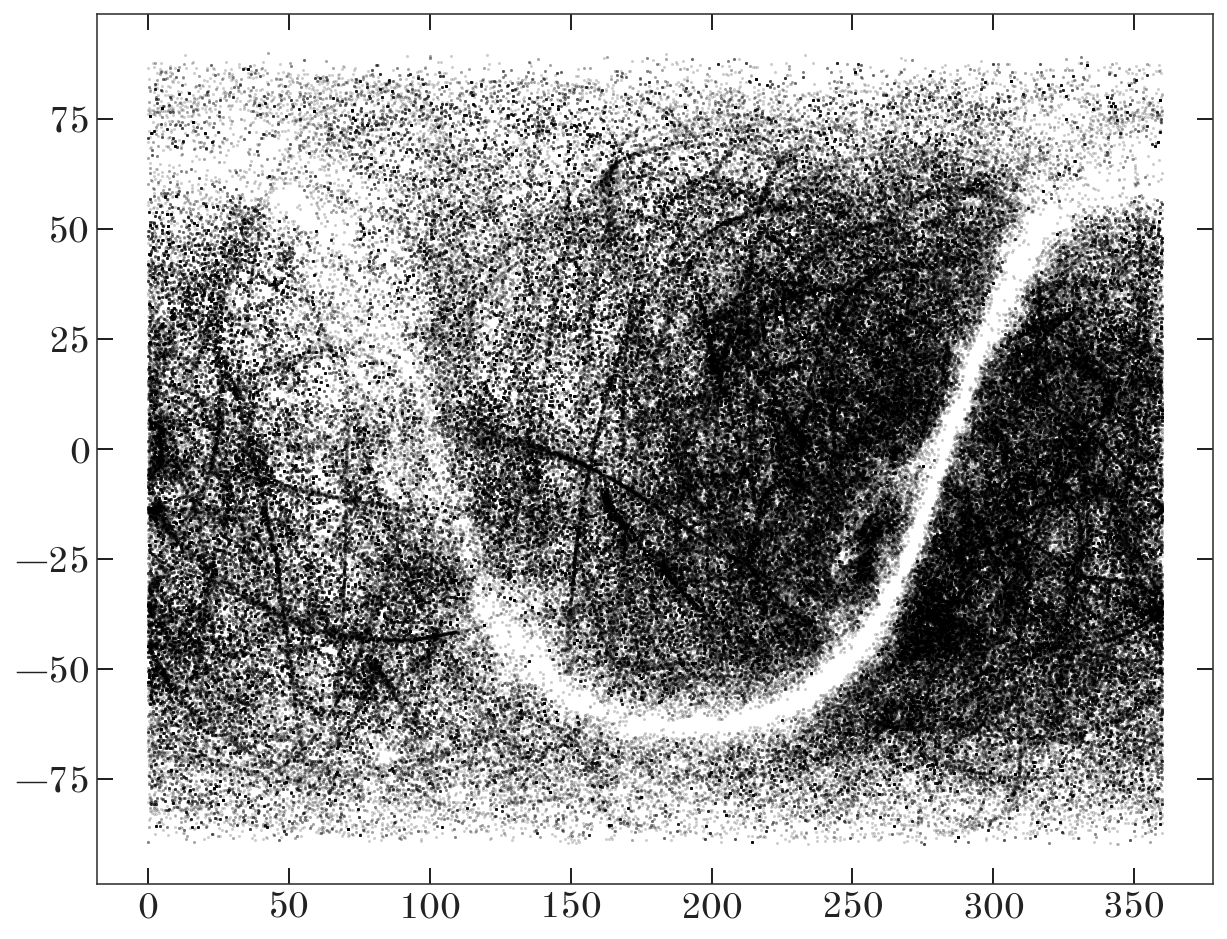

In [262]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(big_tbl['ra'], big_tbl['dec'],
        marker='o', ls='none', mew=0, alpha=0.2, ms=1.5)

(20, 11)

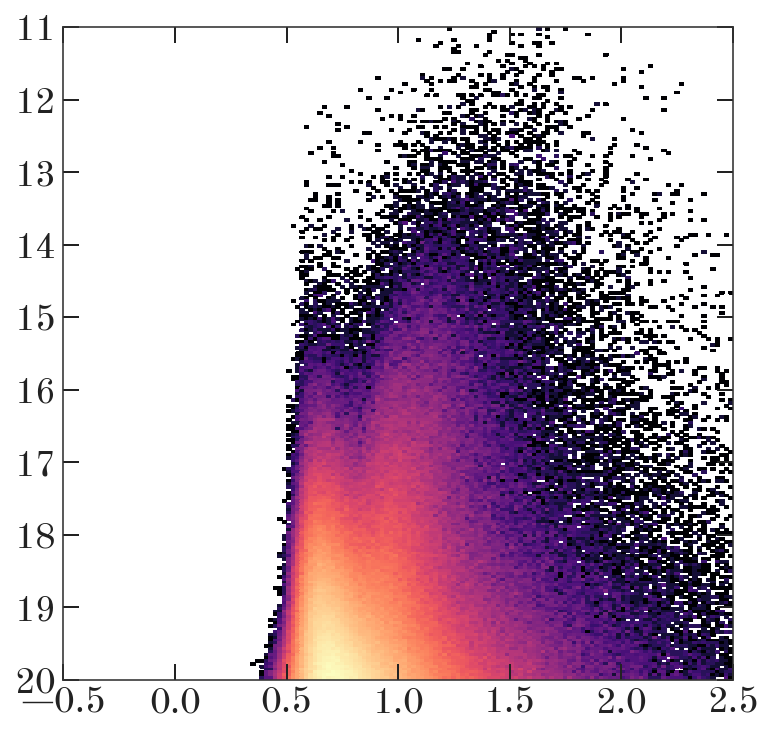

In [273]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.plot(big_tbl['phot_bp_mean_mag'] - big_tbl['phot_rp_mean_mag'],
#         big_tbl['phot_g_mean_mag'],
#         marker='o', ls='none', mew=0, alpha=0.2, ms=1.)
ax.hist2d(big_tbl['phot_bp_mean_mag'] - big_tbl['phot_rp_mean_mag'],
          big_tbl['phot_g_mean_mag'],
          bins=(np.arange(0, 2.5+1e-3, 0.02),
                np.arange(11, 20+1e-3, 0.04)),
          norm=mpl.colors.LogNorm())
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(20, 11)

(-30, 30)

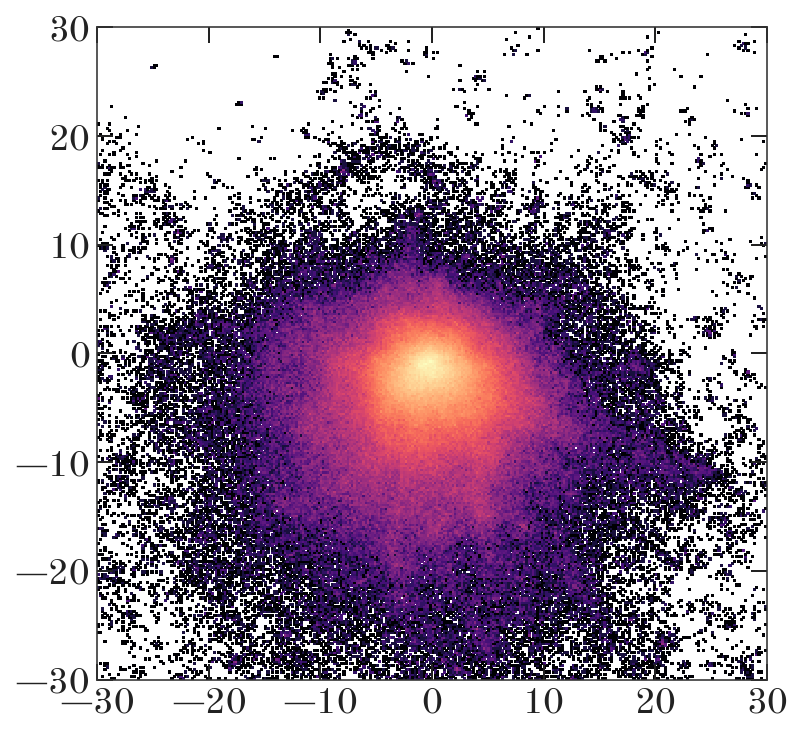

In [271]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.plot(big_tbl['pmra'], big_tbl['pmdec'],
#         marker='o', ls='none', mew=0, alpha=0.2, ms=1.)
ax.hist2d(big_tbl['pmra'], big_tbl['pmdec'],
          bins=np.arange(-30, 30+1e-3, 0.2),
          norm=mpl.colors.LogNorm())
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)